# Tail analysis

In [1]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import symphonypy as sp

import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

g2m_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/G2M_phase.txt", names=["gene"]).gene)
g2m_genes = [gene[0].upper() + gene[1:].lower() for gene in g2m_genes]

s_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/S_phase.txt", names=["gene"]).gene)
s_genes = [gene[0].upper() + gene[1:].lower() for gene in s_genes]

## Embedding construction

In [2]:
reference_injections = [
    "injection34",
    "injection30",
    "injection31",
    "injection32",
]

adata = []
for injection in reference_injections:
    adata.append(sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/{injection}.h5ad"))
adata = adata[0].concatenate(adata[1:], join="outer", batch_key=None, fill_value=0, index_unique=None)
adata.obs["E7.5:clones"] = adata.obs["E7.5:clones"].fillna("NA")
adata.var = adata.var[["gene_ids", "mt"]]
adata = adata[:, ~np.isin(adata.var_names, ["GFPbc", "TOMbc"])]
adata.layers["counts"] = adata.X.copy()
adata.var.mt = adata.var.mt.astype(bool)

adata.write_h5ad(f"{DATA_PATH}/anndatas_counts/tails.h5ad")

In [3]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer="counts",
    n_top_genes=3000,
)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.raw = adata

In [6]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

In [7]:
sp.pp.harmony_integrate(adata, key="sample_id", max_iter_harmony=30, verbose=True)
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.umap(adata)

Harmony integration with harmonypy is preforming.


2025-01-25 19:55:41,361 - harmonypy - INFO - Iteration 1 of 30
2025-01-25 19:56:34,199 - harmonypy - INFO - Iteration 2 of 30
2025-01-25 19:57:29,167 - harmonypy - INFO - Iteration 3 of 30
2025-01-25 19:58:24,055 - harmonypy - INFO - Iteration 4 of 30
2025-01-25 19:59:17,095 - harmonypy - INFO - Iteration 5 of 30
2025-01-25 19:59:38,863 - harmonypy - INFO - Iteration 6 of 30
2025-01-25 20:00:01,474 - harmonypy - INFO - Iteration 7 of 30
2025-01-25 20:00:27,243 - harmonypy - INFO - Iteration 8 of 30
2025-01-25 20:00:49,597 - harmonypy - INFO - Iteration 9 of 30
2025-01-25 20:01:08,501 - harmonypy - INFO - Iteration 10 of 30
2025-01-25 20:01:27,163 - harmonypy - INFO - Iteration 11 of 30
2025-01-25 20:01:46,123 - harmonypy - INFO - Converged after 11 iterations
2025-01-25 20:02:28.734124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 20:02:28.

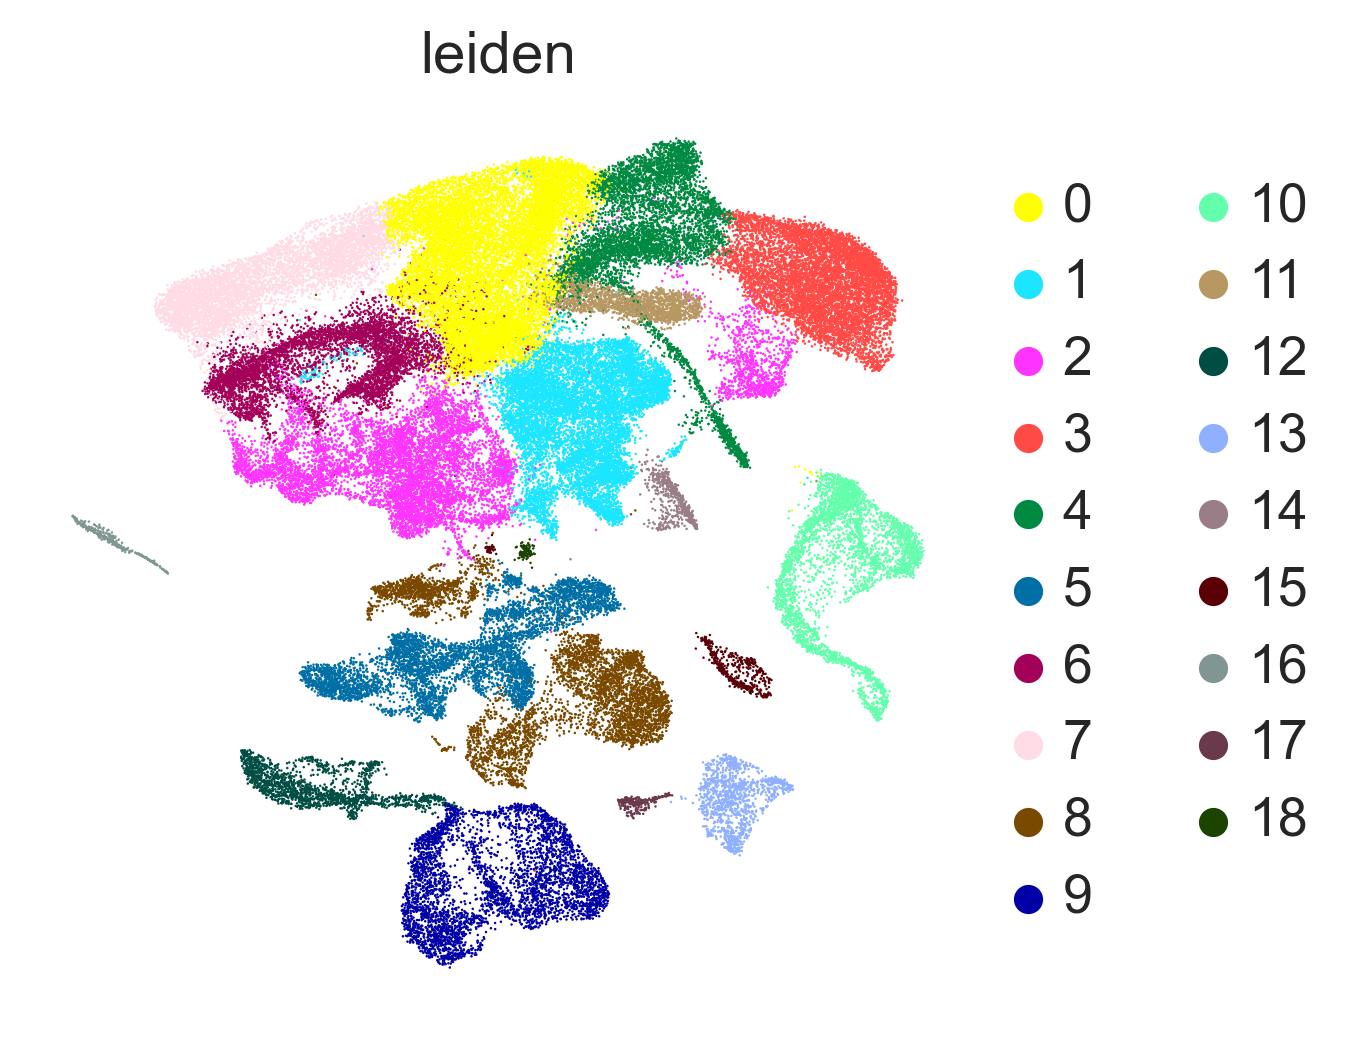

In [224]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden"], frameon=False)

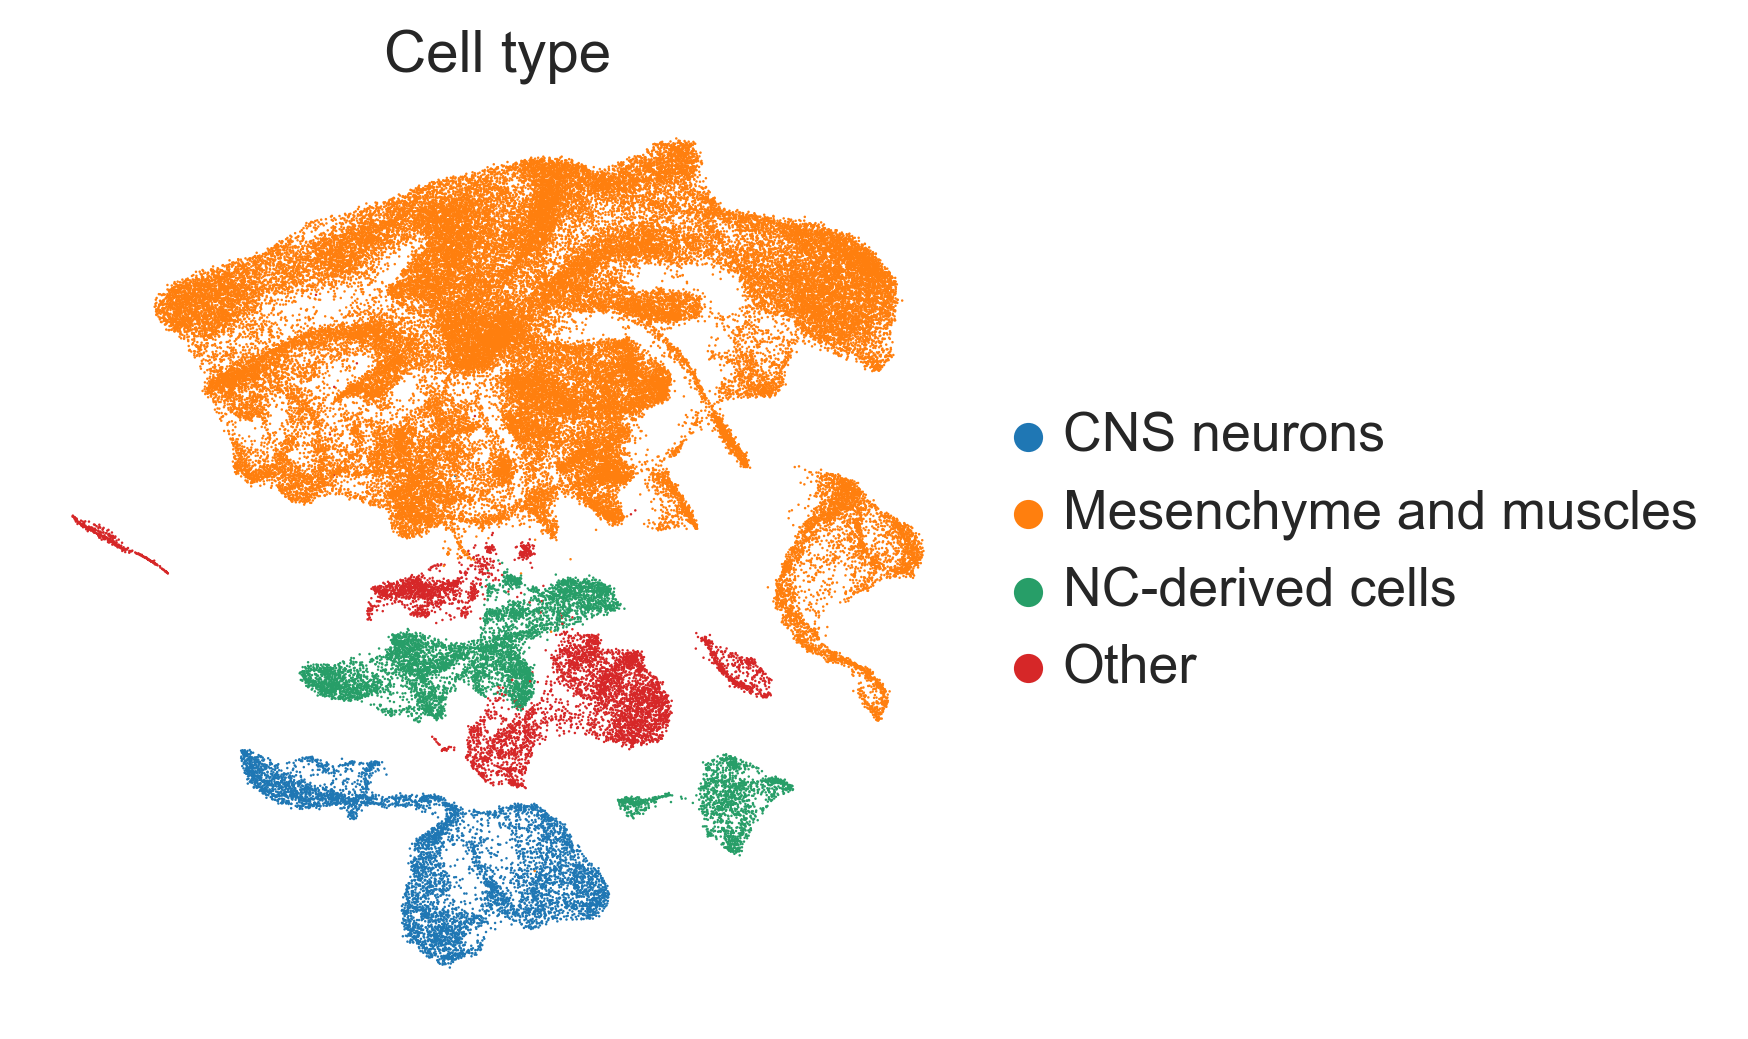

In [230]:
ct_to_leiden = {
    "Mesenchyme and muscles": [0, 1, 2, 3, 4, 6, 7, 10, 11, 14],
    "CNS neurons" : [9, 12],
    "NC-derived cells": [5, 13, 17],
    "Other": [8, 15, 16, 18],
}

leiden_to_ct = {}
for ct in ct_to_leiden:
    for leiden in ct_to_leiden[ct]:
        leiden_to_ct[str(leiden)] = ct
        
adata.obs["celltype_l1"] = [leiden_to_ct[i] for i in adata.obs.leiden]
sc.pl.umap(adata, color="celltype_l1", frameon=False, title="Cell type")

In [239]:
adata.write_h5ad(f"{DATA_PATH}/anndatas/tails_integrations.h5ad")
adata.write_h5ad(f"{DATA_PATH}/cellxgene/tails.h5ad")

## Clonal analysis

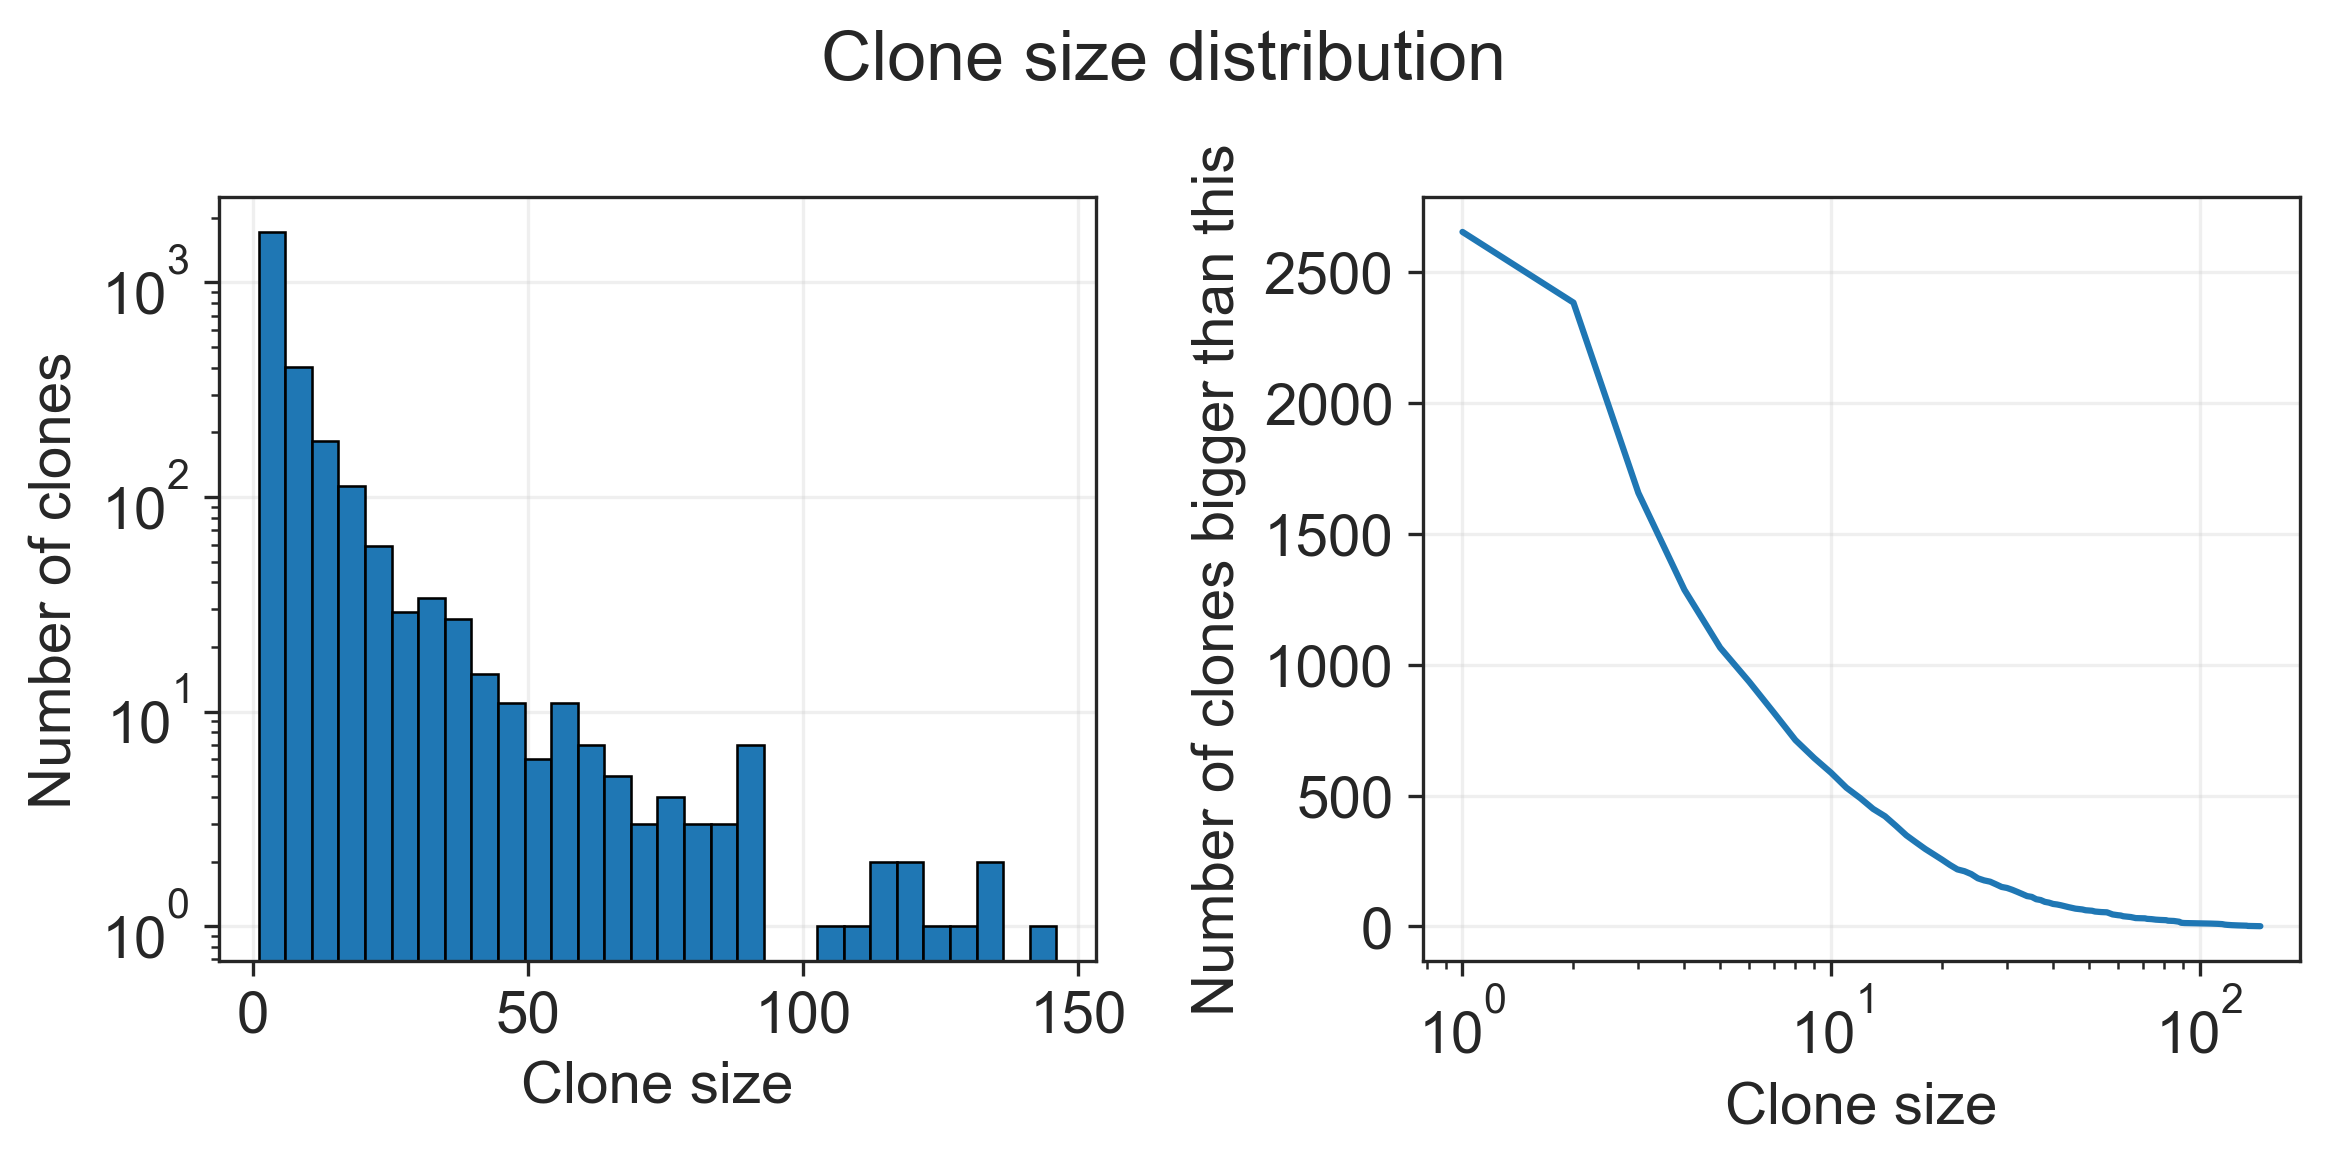

In [12]:
sl.pl.basic_stats(adata, obs_name="E7.5:clones", title="Clone size distribution")

In [17]:
sl.tl.clonal_nn(
    adata,
    obs_name="E7.5:clones",
    use_rep="X_pca",
    min_size=3,
    tqdm_bar=True,
)

100%|██████████| 83386/83386 [01:22<00:00, 1006.55it/s]


In [26]:
clones = sl.tl.clone2vec(
    adata,
    fill_ct="celltype_l1",
    obs_name="E7.5:clones",
    device="cuda:0",
    n_epochs=150,
)

100%|██████████| 150/150 [16:47<00:00,  6.72s/it]


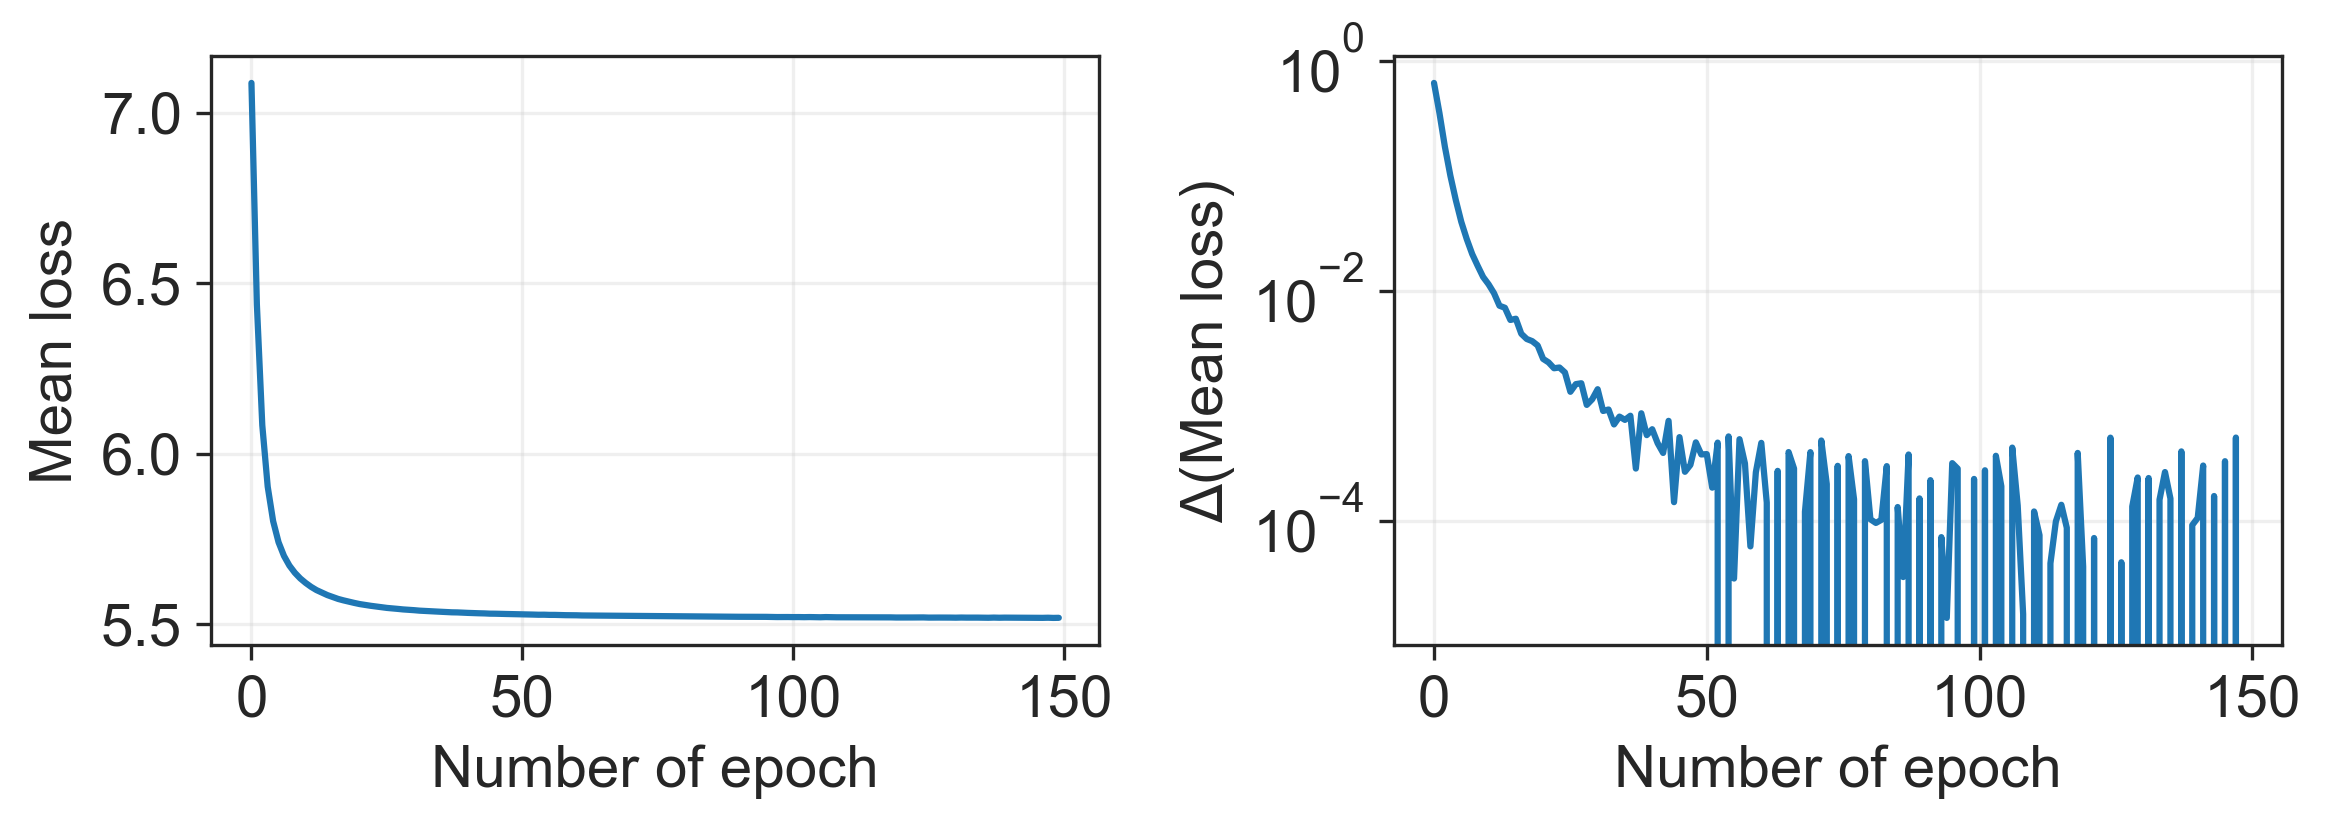

In [240]:
sl.pl.epochs_loss(clones)

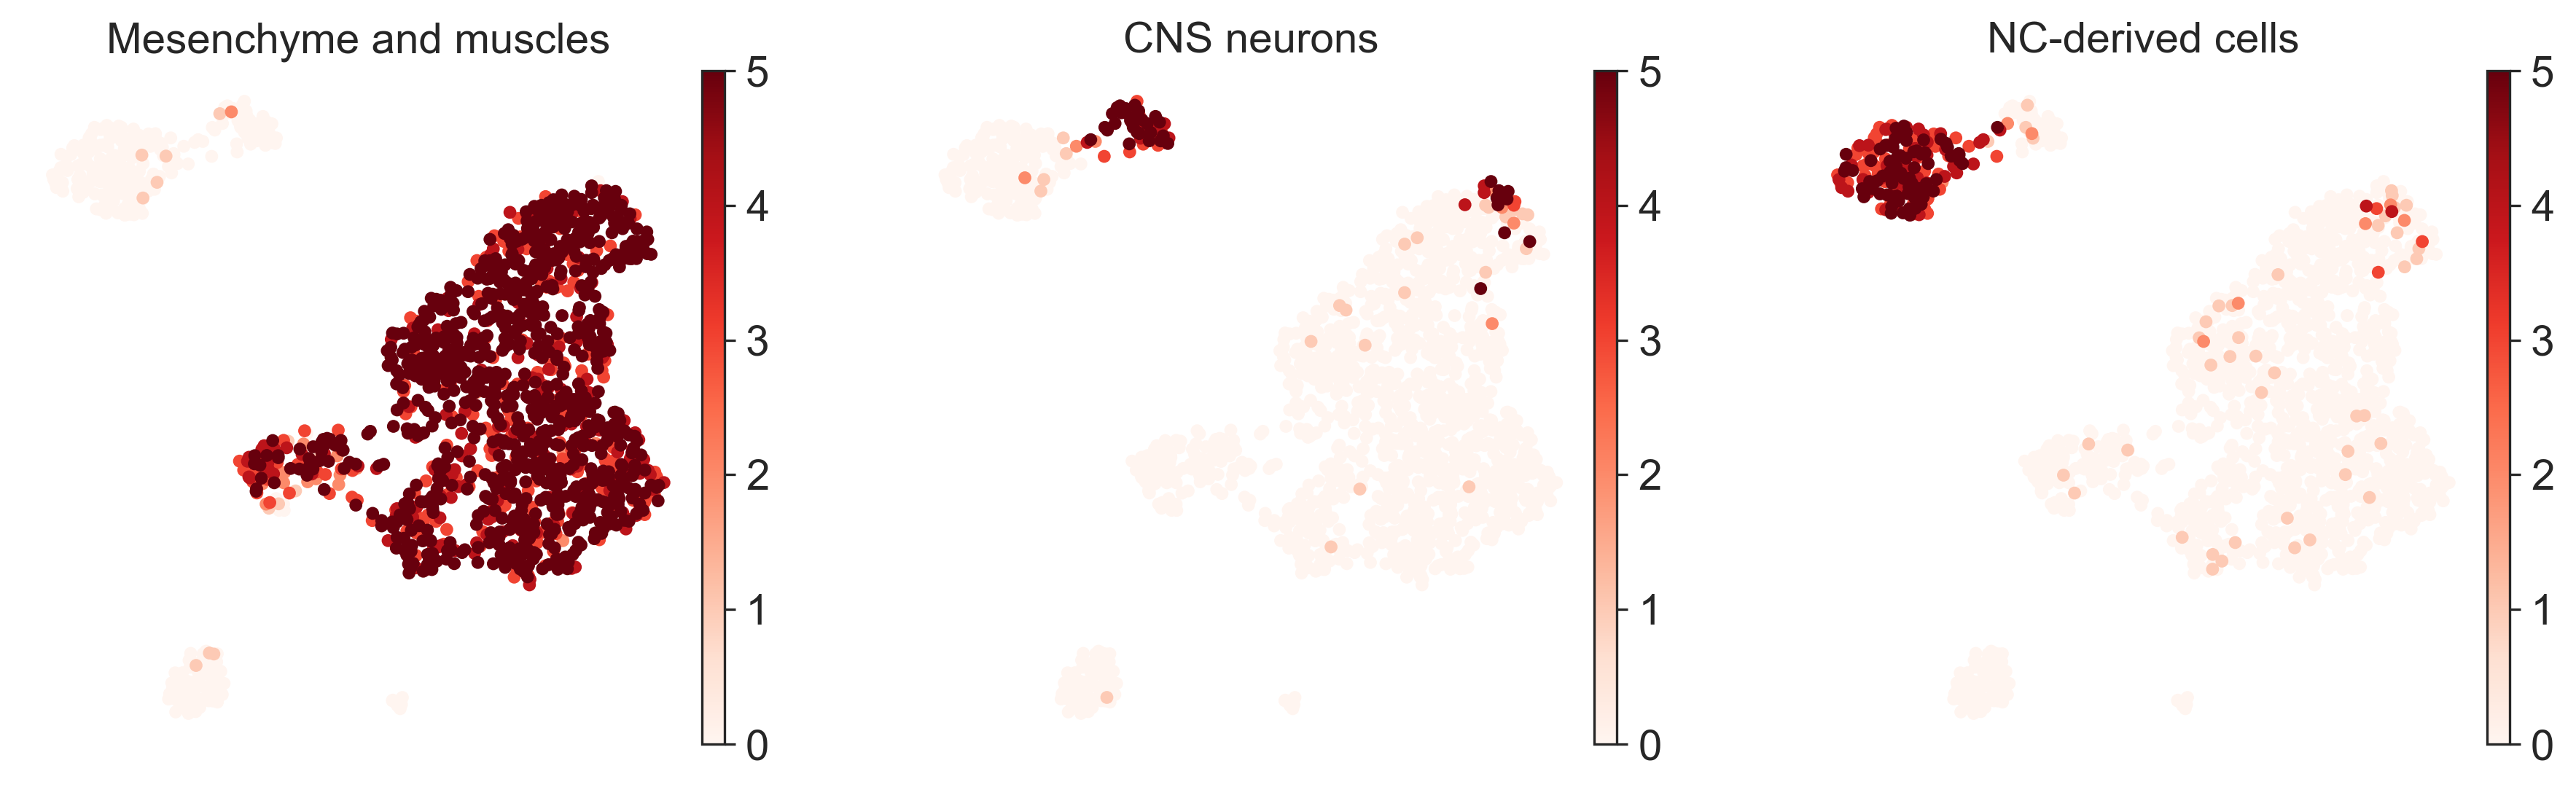

In [257]:
sc.pp.neighbors(clones, use_rep="clone2vec", n_neighbors=15)
sc.tl.umap(clones)

sc.pl.umap(
    clones,
    color=[
        "Mesenchyme and muscles", "CNS neurons",
        "NC-derived cells"
    ],
    vmax=5,
    cmap="Reds",
    frameon=False,
)

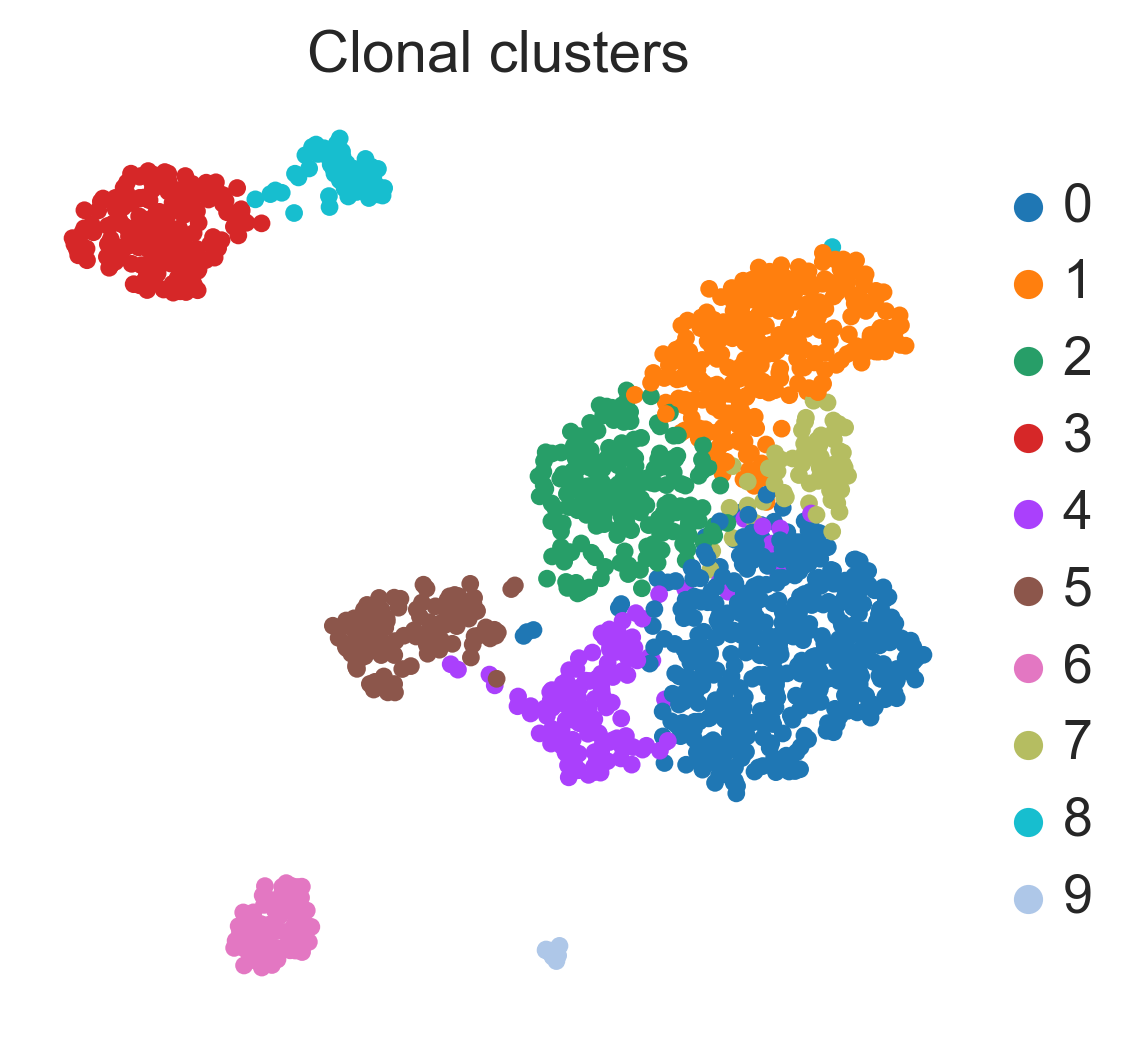

In [263]:
sc.tl.leiden(clones, resolution=0.5)

sc.pl.umap(clones, color="leiden", title="Clonal clusters", frameon=False)

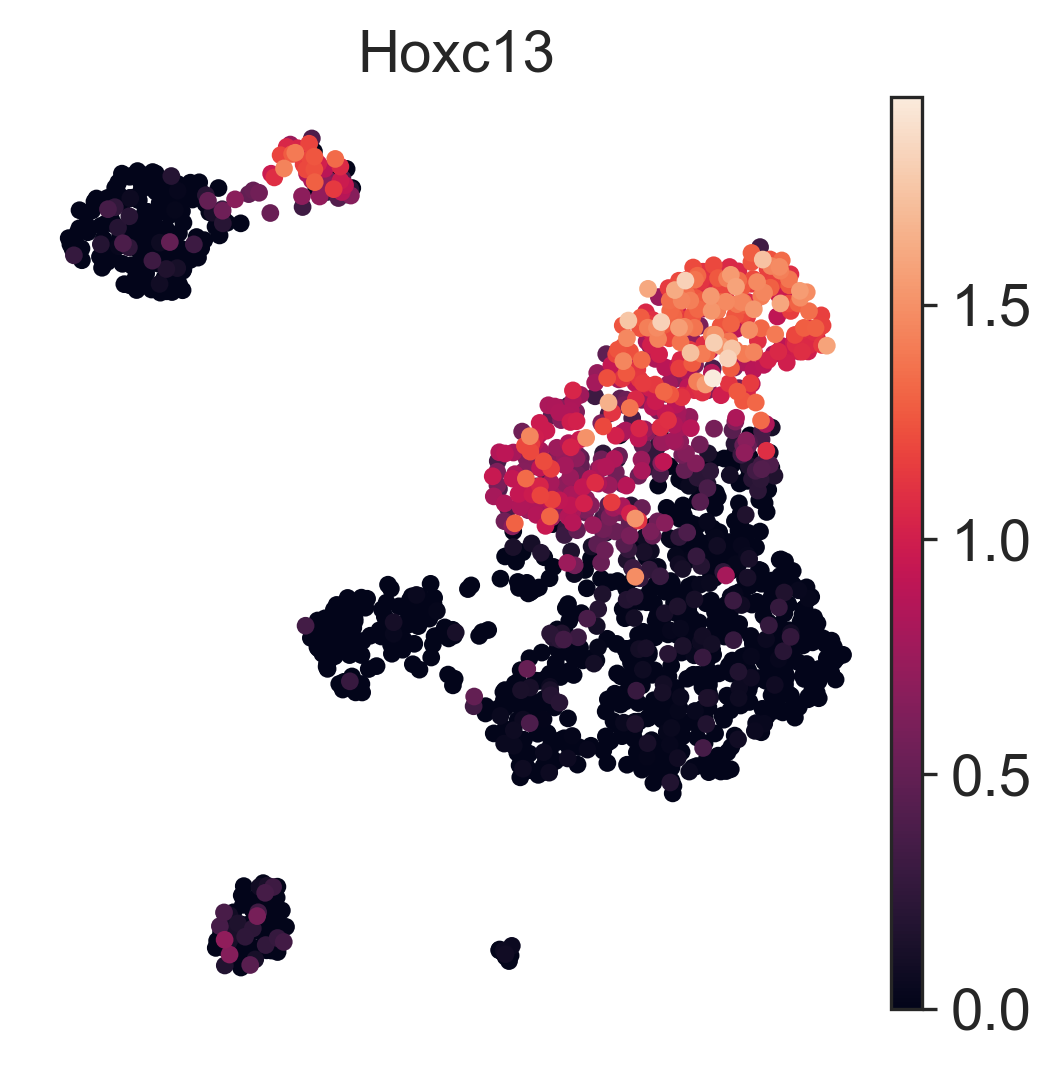

In [267]:
clones_expression = sl.tl.summarize_expression(
    adata=adata,
    clones=clones,
    obs_name="E7.5:clones",
)

sc.pl.umap(clones_expression, color="Hoxc13", frameon=False)

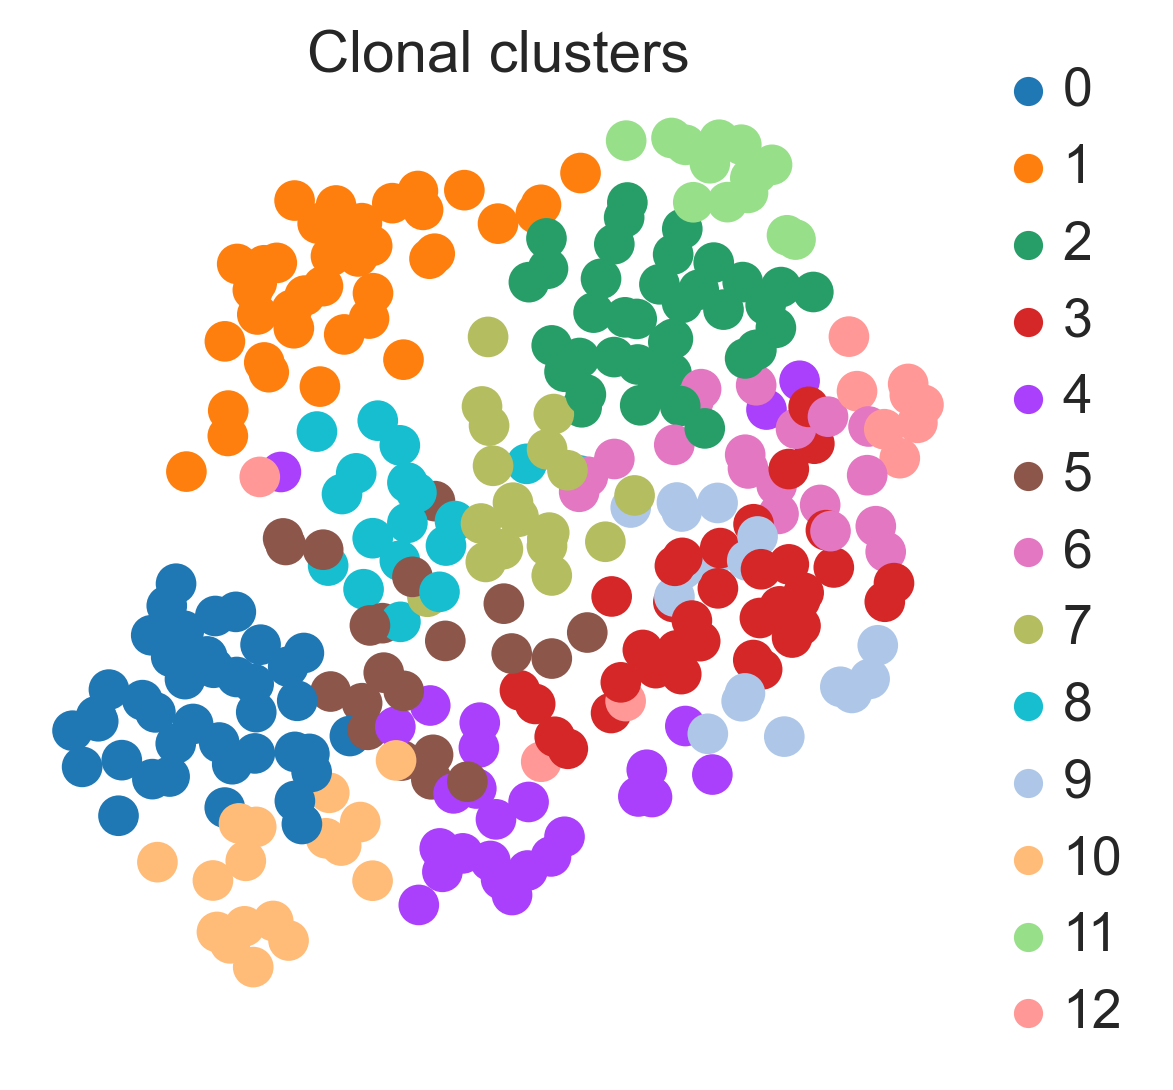

In [271]:
clones_mes_tail = clones[clones.obs.leiden == "1"].copy()

sc.pp.neighbors(
    clones_mes_tail,
    use_rep="clone2vec",
    n_neighbors=10,
)
sc.tl.umap(clones_mes_tail)
sc.tl.leiden(clones_mes_tail, resolution=1.5)

sc.pl.umap(
    clones_mes_tail,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
)

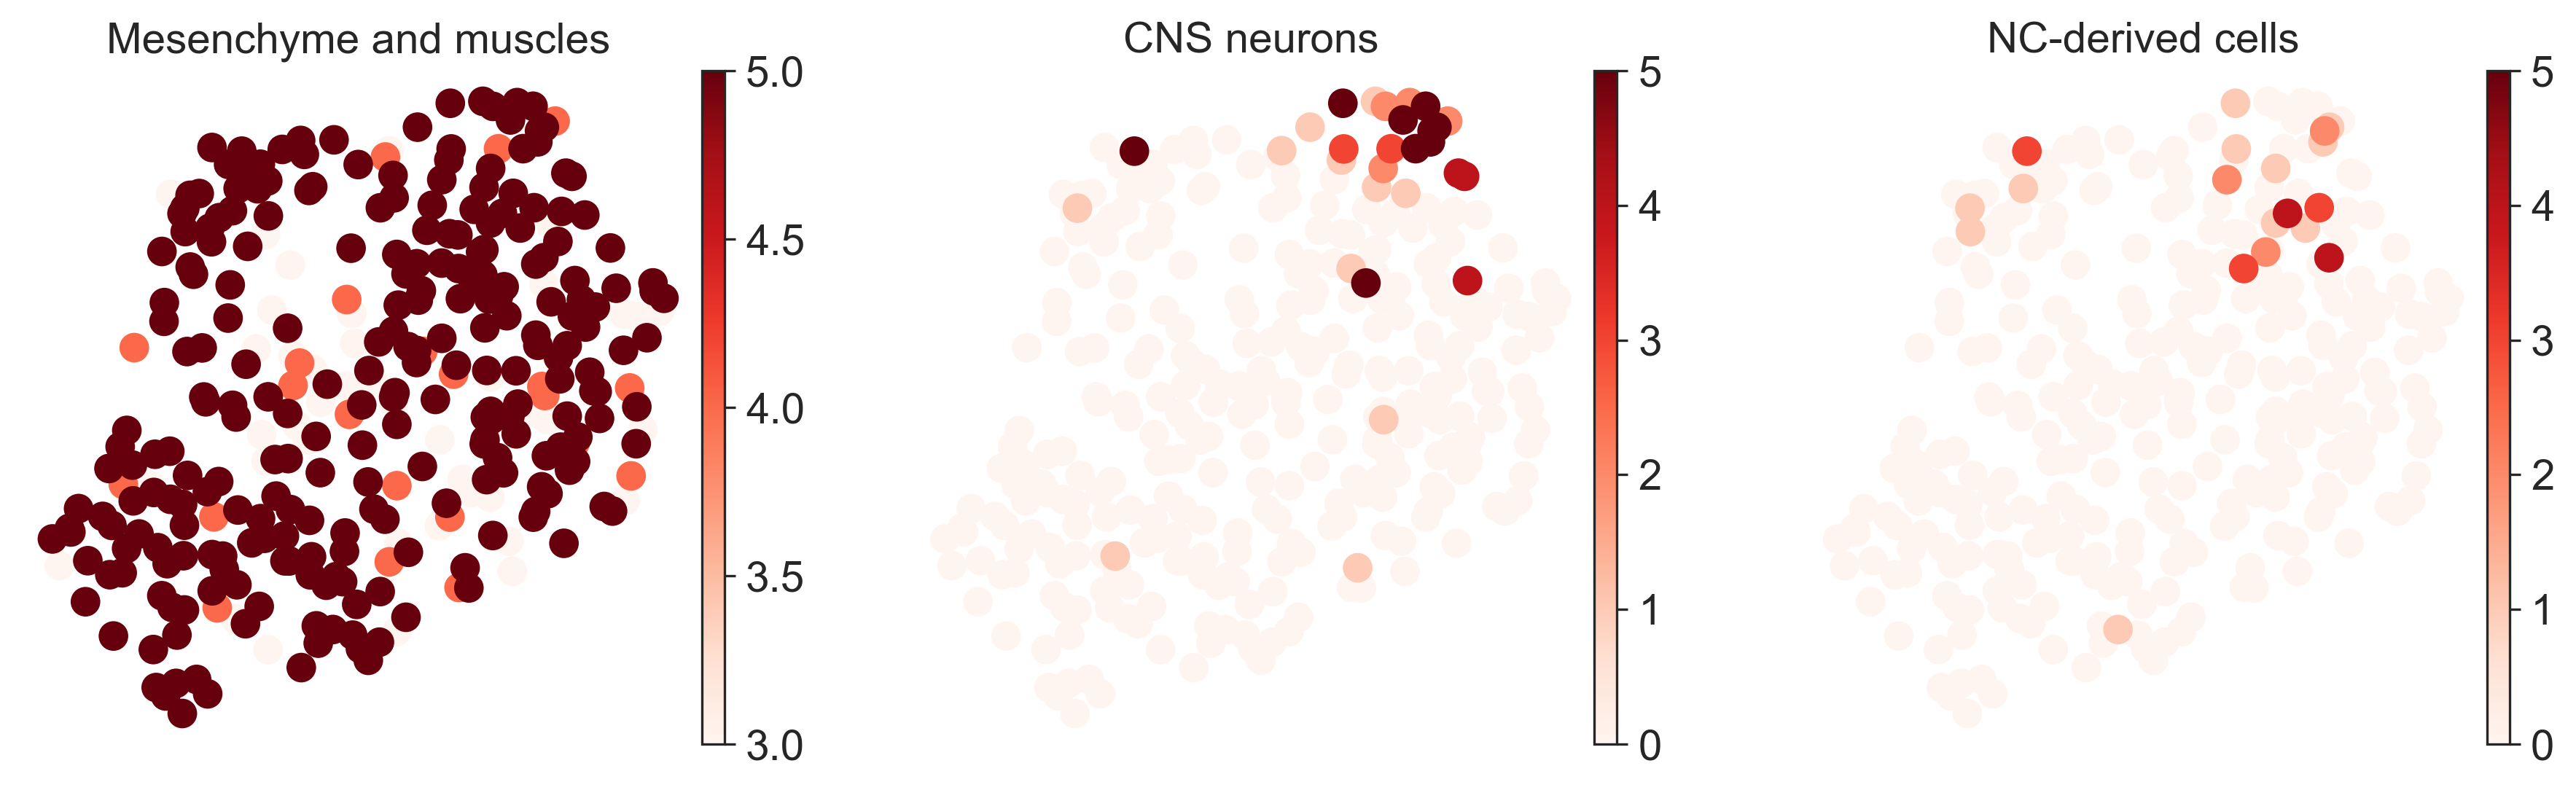

In [272]:
sc.pl.umap(
    clones_mes_tail,
    color=[
        "Mesenchyme and muscles", "CNS neurons",
        "NC-derived cells"
    ],
    vmax=5,
    cmap="Reds",
    frameon=False,
)

<Axes: >

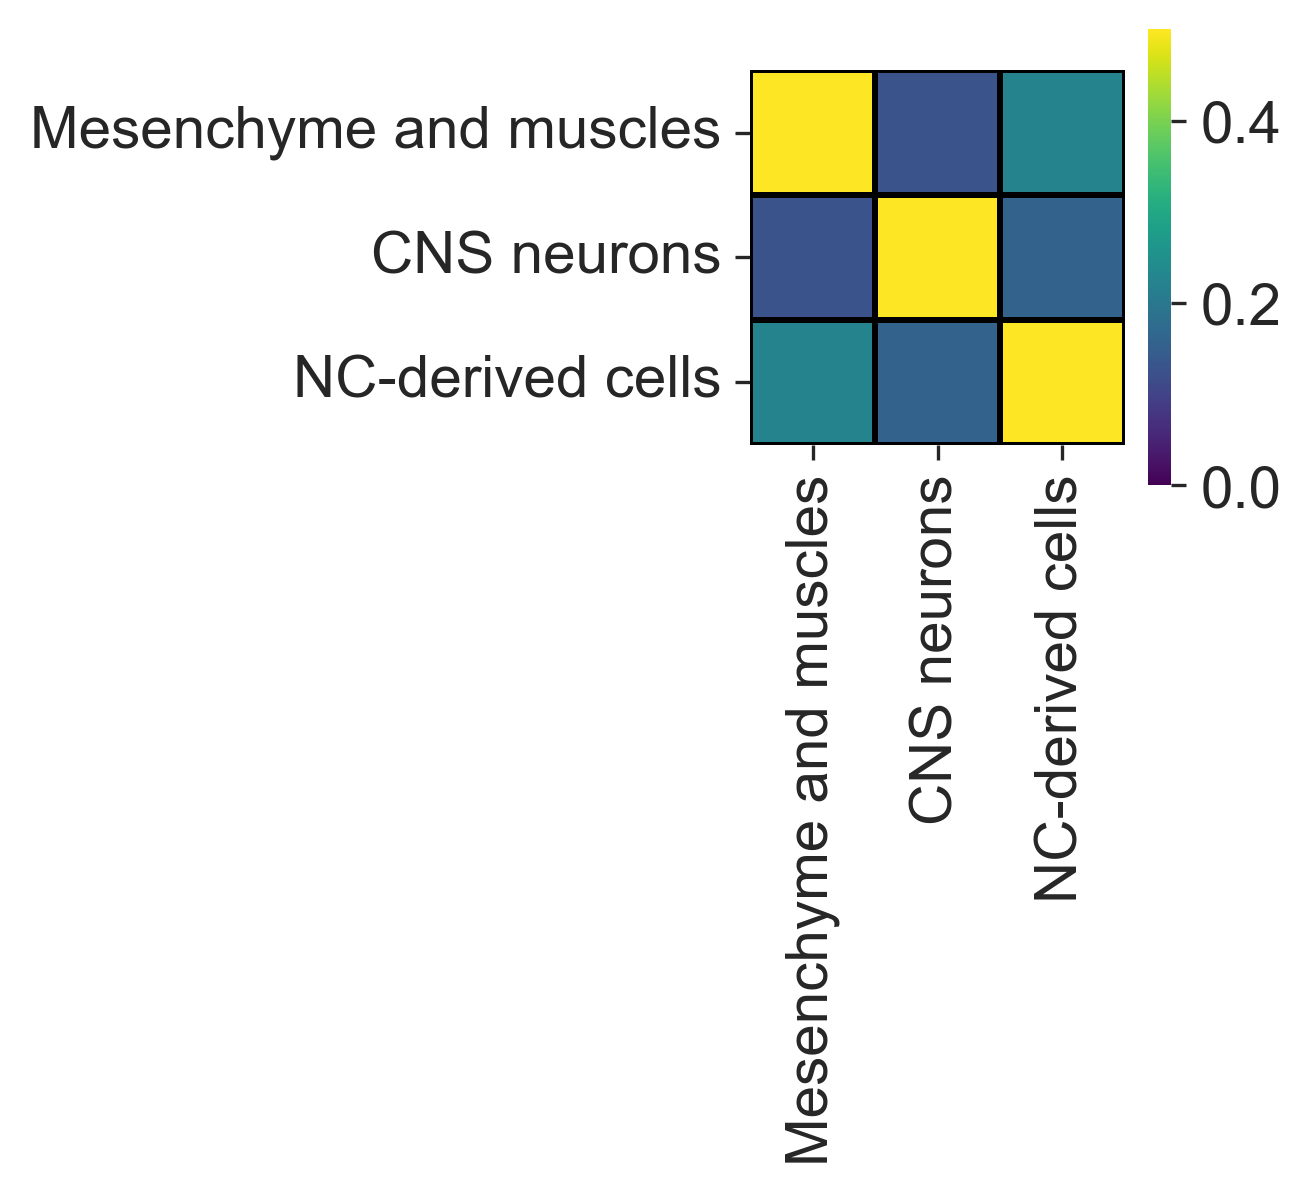

In [274]:
target_columns = ["Mesenchyme and muscles", "CNS neurons", "NC-derived cells"]

correlations = pd.DataFrame(
    clones_mes_tail[:, target_columns].X,
    columns=target_columns,
).corr()

fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(
    correlations,
    vmin=0,
    ax=ax,
    square=True,
    vmax=0.5,
    cmap="viridis",
    linewidth=1,
    linecolor="black",
)

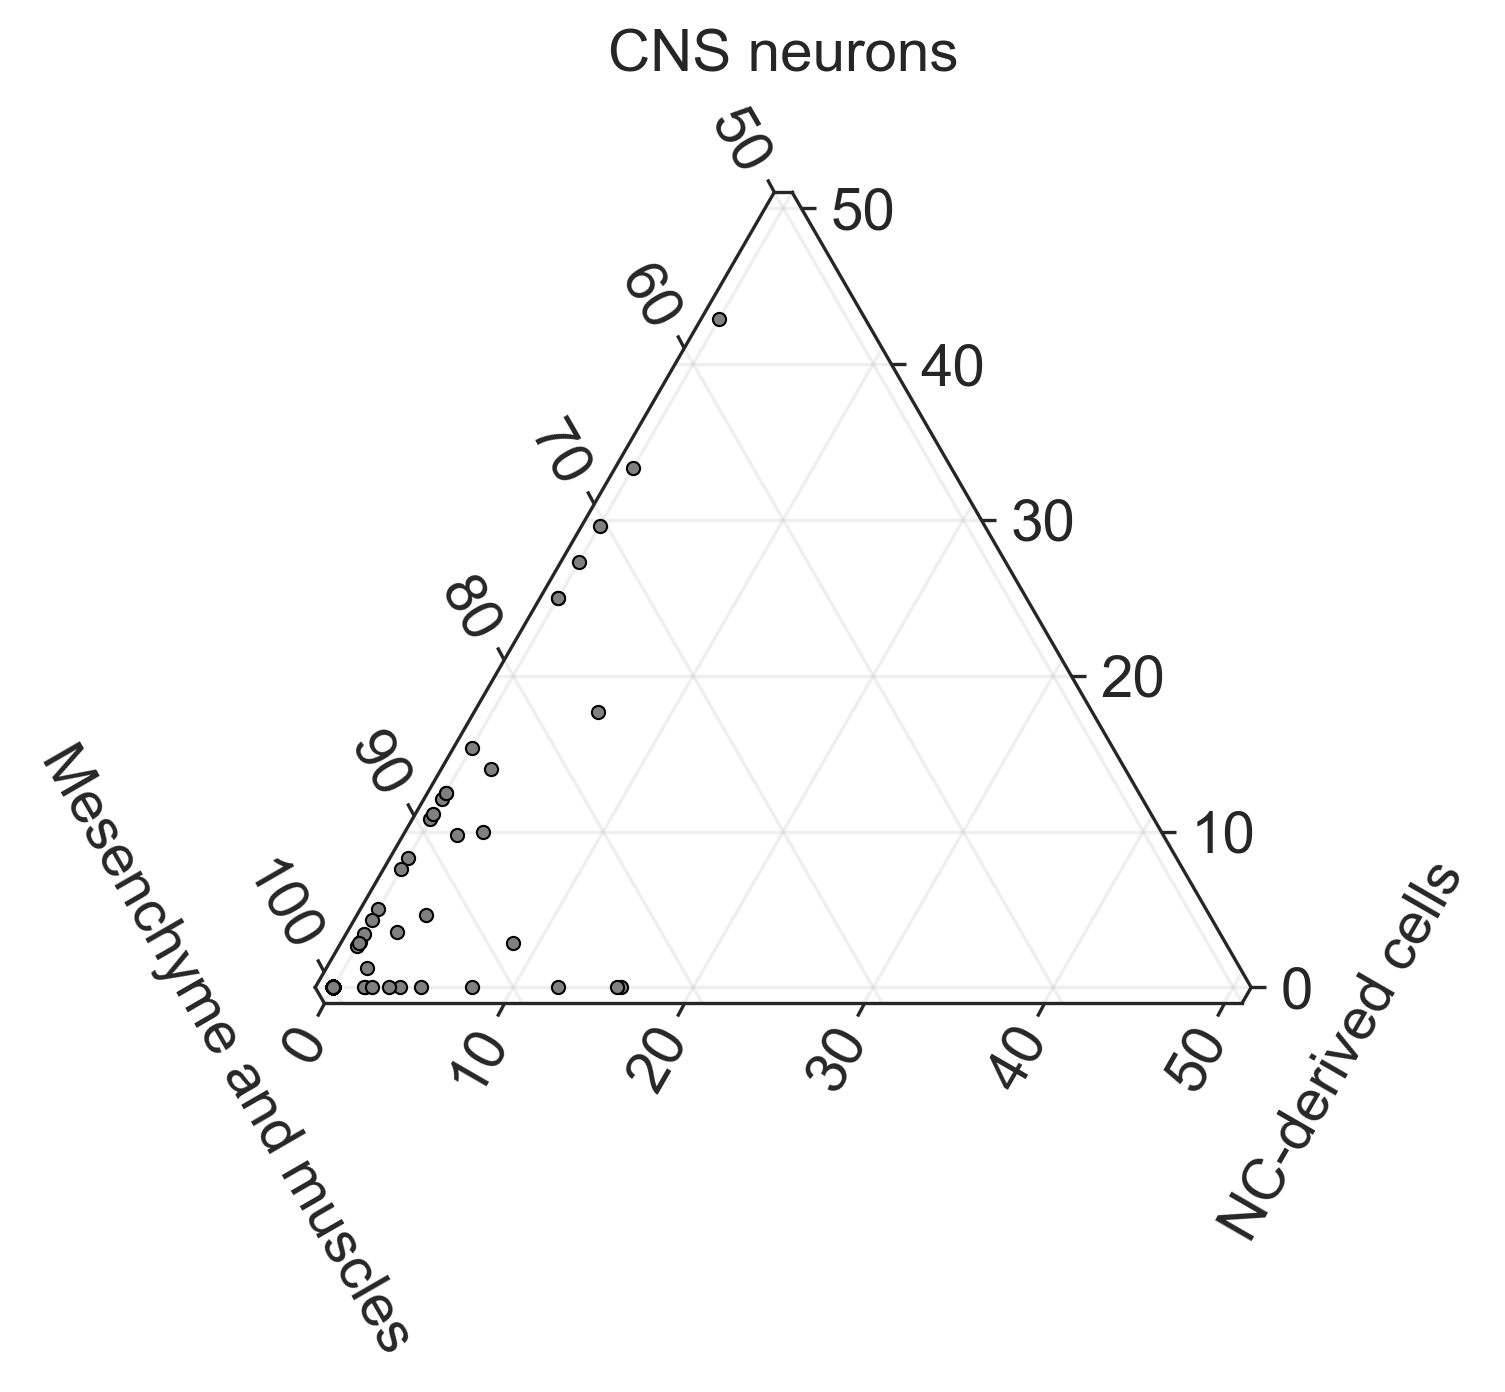

In [341]:
import mpltern

ax = plt.subplot(projection="ternary", ternary_sum=100)

ax.set_tlabel("CNS neurons")
ax.set_llabel("Mesenchyme and muscles")
ax.set_rlabel("NC-derived cells")

# Order = top, left, right
ax.scatter(
    clones_mes_tail[:, "CNS neurons"].layers["frequencies"].T[0],
    clones_mes_tail[:, "Mesenchyme and muscles"].layers["frequencies"].T[0],
    clones_mes_tail[:, "NC-derived cells"].layers["frequencies"].T[0],
    s=10,
    color="grey",
    edgecolor="k",
    linewidth=0.5,
)

ax.grid(alpha=0.3)

ax.set_tlim(-1, 51)
ax.set_llim(49, 101)
ax.set_rlim(-1, 51)

Text(0, 0.5, 'Number of clones')

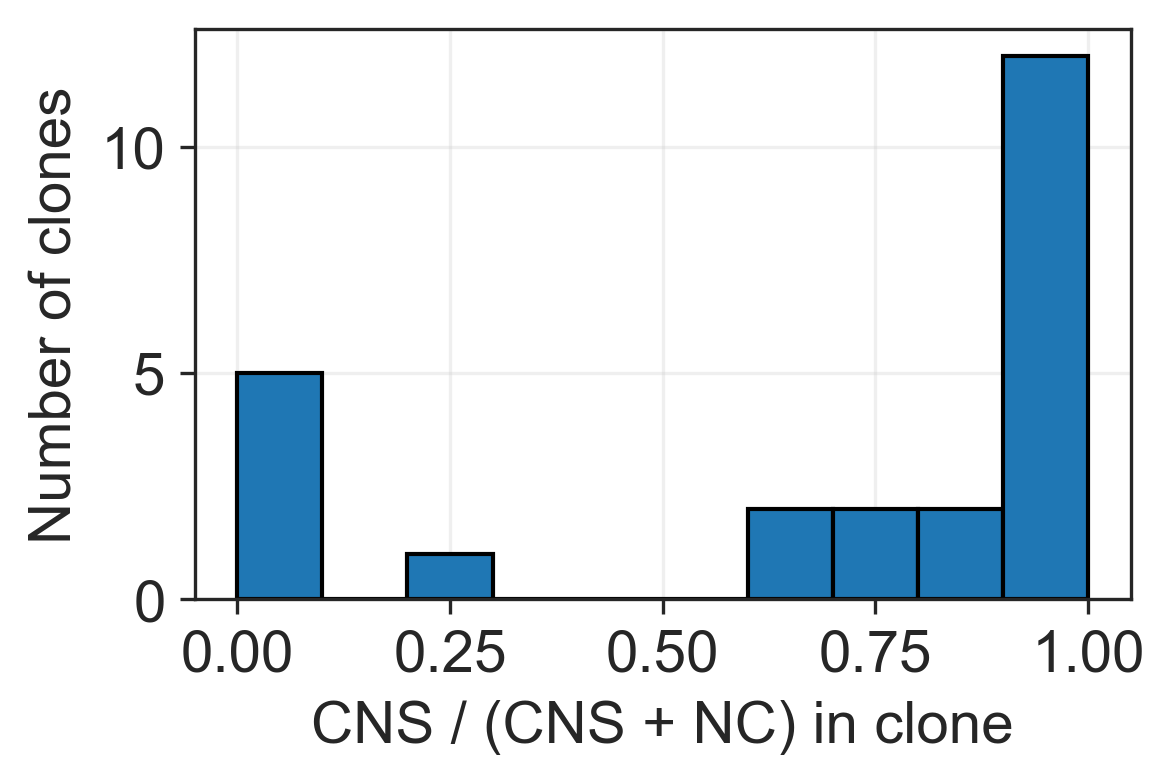

In [277]:
neurons_proportion = (
    clones_mes_tail[:, "CNS neurons"].X.T[0] / (
        clones_mes_tail[:, "CNS neurons"].X.T[0] +
        clones_mes_tail[:, "NC-derived cells"].X.T[0]
    )
)

min_neurons = min_NC = 2

neurons_proportion = neurons_proportion[
    (~np.isnan(neurons_proportion)) & ((
        clones_mes_tail[:, "CNS neurons"].X.T[0] >= min_neurons
    ) | (
        clones_mes_tail[:, "NC-derived cells"].X.T[0] >= min_NC
    ))
]

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.histplot(
    neurons_proportion,
    bins=10,
    edgecolor="black",
    ax=ax,
    alpha=1,
)
ax.grid(alpha=0.3)
ax.set_xlabel("CNS / (CNS + NC) in clone")
ax.set_ylabel("Number of clones")

In [308]:
NC2 = clones_mes_tail[clones_mes_tail.obs.leiden == "2", "NC-derived cells"].X.T[0]
CNS2 = clones_mes_tail[clones_mes_tail.obs.leiden == "2", "CNS neurons"].X.T[0]
NC11 = clones_mes_tail[clones_mes_tail.obs.leiden == "11", "NC-derived cells"].X.T[0]
CNS11 = clones_mes_tail[clones_mes_tail.obs.leiden == "11", "CNS neurons"].X.T[0]

NC2 = np.log1p(NC2)
CNS2 = np.log1p(CNS2)
NC11 = np.log1p(NC11)
CNS11 = np.log1p(CNS11)

labels = ["2"] * sum(clones_mes_tail.obs.leiden == "2") + ["11"] * sum(clones_mes_tail.obs.leiden == "11")
df_to_plot = pd.DataFrame({
    "Cluster": labels,
    "CNS neurons": np.concatenate([CNS2, CNS11]),
    "NC-derived cells": np.concatenate([NC2, NC11]),
})

from scipy.stats import mannwhitneyu

p_CNS = np.round(mannwhitneyu(CNS2, CNS11).pvalue, 4)
p_NC = np.round(mannwhitneyu(NC2, NC11).pvalue, 4)

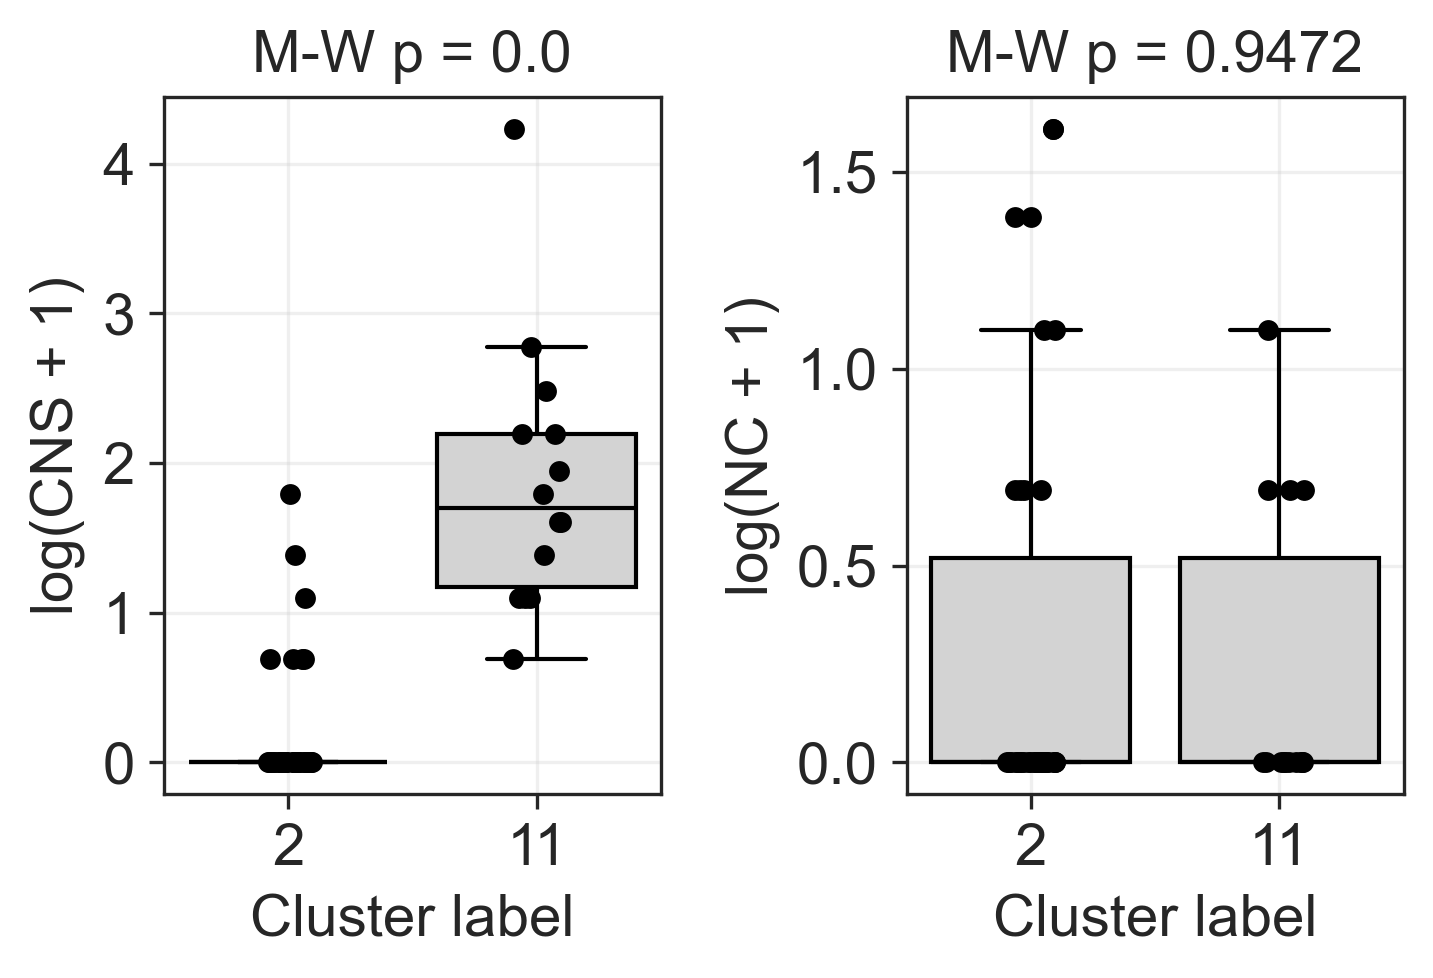

In [342]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 3.5))

sns.boxplot(x="Cluster", y="CNS neurons", data=df_to_plot, ax=axes[0], showfliers=False,
            color="lightgrey", **black_borders_boxplot)
sns.stripplot(x="Cluster", y="CNS neurons", data=df_to_plot, ax=axes[0], color="black", s=5)
axes[0].grid(alpha=0.3)
axes[0].set_ylabel("log(CNS + 1)")
axes[0].set_xlabel("Cluster label")
axes[0].set_title(f"M-W p = {p_CNS}")

sns.boxplot(x="Cluster", y="NC-derived cells", data=df_to_plot, ax=axes[1], showfliers=False,
            color="lightgrey", **black_borders_boxplot)
sns.stripplot(x="Cluster", y="NC-derived cells", data=df_to_plot, ax=axes[1], color="black", s=5)
axes[1].grid(alpha=0.3)
axes[1].set_ylabel("log(NC + 1)")
axes[1].set_xlabel("Cluster label")
axes[1].set_title(f"M-W p = {p_NC}")

fig.tight_layout()

In [332]:
clones_mes_tail.write_h5ad("NC-NMP/clones_mes_tail.h5ad")
clones_expression.write_h5ad("NC-NMP/clones_expression.h5ad")
clones.write_h5ad(f"{DATA_PATH}/anndatas/tails_clone2vec.h5ad")